In [5]:
import pandas as pd 
import numpy as np 

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns 
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['font.size'] = 10
sns.set()

In [6]:
data = pd.read_csv('surnames_with_splits.csv')

In [7]:
data.head()

,surname,nationality,split
0,Totah,Arabic,train
1,Abboud,Arabic,train
2,Fakhoury,Arabic,train
3,Srour,Arabic,train
4,Sayegh,Arabic,train


In [8]:
data.shape

(10980, 3)

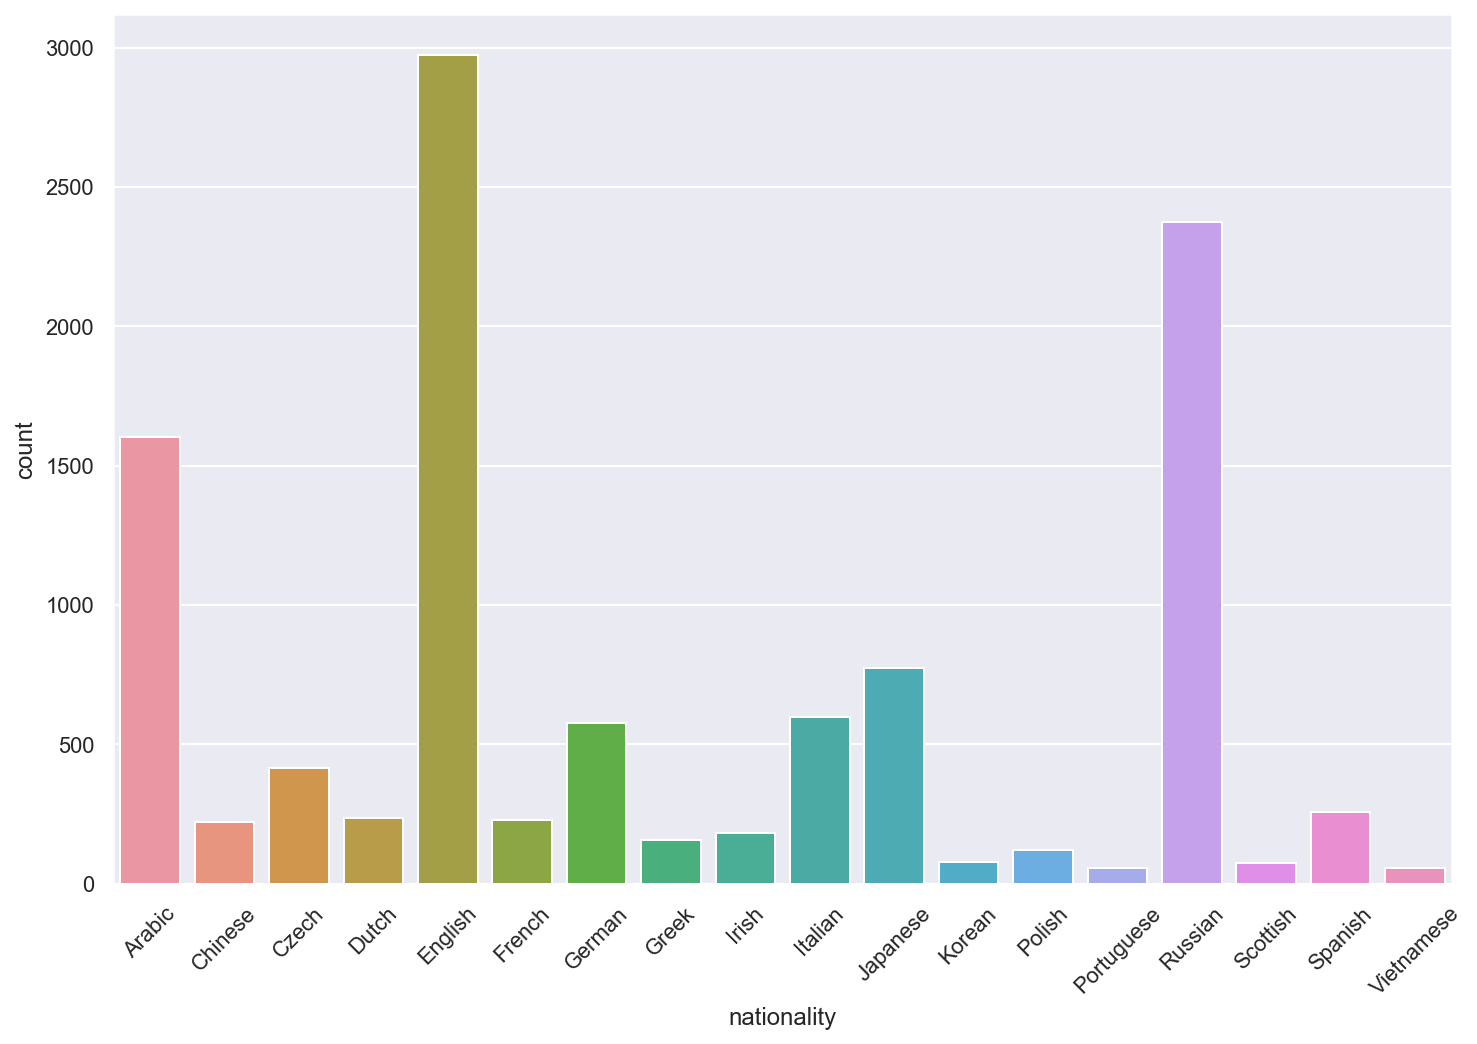

In [9]:
#unbalanced data 
sns.countplot(x = data.nationality)
plt.xticks(rotation=45)
plt.show()

In [10]:
frequencies = torch.tensor(data.nationality.value_counts().sort_values().reset_index()\
                .sort_values(by = 'index').nationality.values)
total_samples = torch.sum(frequencies)
class_weights = total_samples / (frequencies.float())

In [11]:
class_weights

tensor([  6.8497,  49.9091,  26.5217,  46.5254,   3.6945,  47.9476,  19.0625,
         70.3846,  60.0000,  18.3000,  14.1677, 142.5974,  91.5000, 199.6364,
          4.6271, 146.4000,  42.5581, 189.3103])

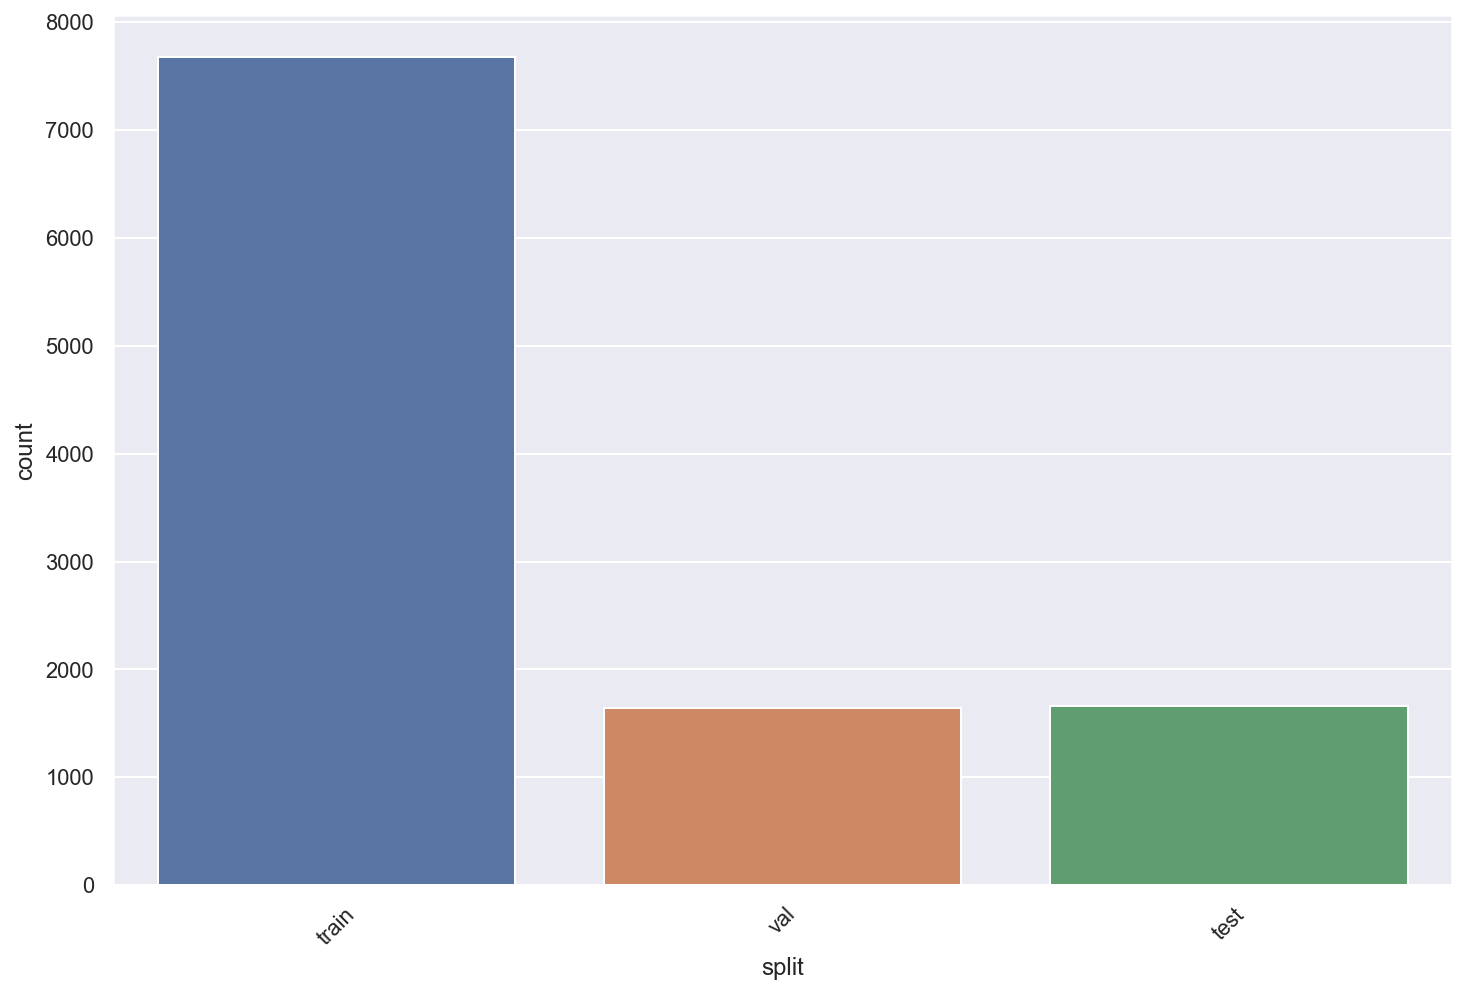

In [12]:
sns.countplot(x = data.split)
plt.xticks(rotation=45)
plt.show()

# Vectorising chars 

In [13]:
class Vocabulary():
    def __init__(self):
        self.vocabulary = ['<sos>', '<eos>', '<pad>'] 
        self.vocabulary.extend('abcdefghijklmnopqrstuvwxyz')
        self._idx2char = {i: char for i, char in enumerate(self.vocabulary)}
        self._char2idx = {char: i for i, char in enumerate(self.vocabulary)}
        
    def get_vocabulary(self):
        return self.vocabulary
    
    def get_sos(self):
        return self.char2idx('<sos>')

    def get_eos(self):
        return self.char2idx('<eos>')

    def get_pad(self):
        return self.char2idx('<pad>')
    
    def idx2char(self, idx: int):
        if idx not in self._idx2char:
            return self.get_pad()
        return self._idx2char[idx]
    
    def char2idx(self, char: str):
        if char not in self._char2idx:
            return self.get_pad()
        return self._char2idx[char]
    
    def encode(self, text):
        result = [self.char2idx(char) for char in text]
        result = [self.get_sos()] + result + [self.get_eos()]
        return result  

In [14]:
class Surname(Dataset):
    def __init__(self, data):
        self.data = data
        self.vocab = Vocabulary()
        self.label2idx = {'Arabic': 0, 'Chinese': 1, 'Czech': 2, 'Dutch': 3, 'English': 4, 'French': 5, 'German': 6,
                          'Greek': 7, 'Irish': 8, 'Italian': 9, 'Japanese': 10, 'Korean': 11, 'Polish': 12,
                          'Portuguese': 13, 'Russian': 14, 'Scottish': 15, 'Spanish': 16, 'Vietnamese': 17}
        self.idx2label = {v: k for k, v in self.label2idx.items()}

    def __getitem__(self, idx):
        surname = self.data['surname'].loc[idx].lower()
        label = self.label2idx[self.data['nationality'].loc[idx]]
        return torch.LongTensor(self.vocab.encode(surname)), torch.LongTensor([label])

    def __len__(self):
        return len(self.data)

In [15]:
traindata = Surname(data[data.split == 'train'].reset_index())
valdata = Surname(data[data.split == 'val'].reset_index())
testdata = Surname(data[data.split == 'test'].reset_index())

In [16]:
traindata[0]

(tensor([ 0, 22, 17, 22,  3, 10,  1]), tensor([0]))

In [17]:
#looks like truth 
data[data.split == 'train'].reset_index().loc[0]

index               0
surname         Totah
nationality    Arabic
split           train
Name: 0, dtype: object

# Fixing batch length problem and making dataloaders

In [18]:
pad_idx = traindata.vocab.get_pad()
def collate_fn(batch):
    surnames = pad_sequence([b[0] for b in batch], padding_value=pad_idx, batch_first=True)
    labels = torch.stack([b[1] for b in batch])
    return surnames, labels

In [102]:
train_loader = DataLoader(traindata, batch_size=64, collate_fn=collate_fn, pin_memory=True, shuffle=True)
valid_loader = DataLoader(valdata, batch_size=64, collate_fn=collate_fn, pin_memory=True, shuffle=True)
test_loader = DataLoader(testdata, batch_size=64, collate_fn=collate_fn, pin_memory=True, shuffle=True)

# Building NN

In [142]:
class SurnameClassifier(nn.Module):
    
    def __init__(self, num_tokens: int, output_size: int, emb_size: int=100, hidden_size: int=64):
        super().__init__()
        self.embedding = nn.Embedding(num_tokens, emb_size, padding_idx = pad_idx)
        self.rnn = nn.GRU(
            input_size=emb_size,
            hidden_size=hidden_size,
            num_layers=4,
            dropout=0.1,
            batch_first=True
        )
        self.output = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, output_size)
        )
    
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = self.output(x[:, -1, :])
        return x

In [143]:
num_tokens = len(traindata.vocab.get_vocabulary())
output_size = len(traindata.label2idx)

In [144]:
model = SurnameClassifier(num_tokens, output_size)

# Training 

In [145]:
optimizer = Adam(model.parameters(), lr=5e-4)
loss_fn = nn.CrossEntropyLoss(ignore_index=pad_idx, weight = class_weights)

In [146]:
def train(model):
    model.train()
    train_loss = 0
    correct_predictions = 0
    for batch in train_loader:
        optimizer.zero_grad()
        output = model(batch[0])
        loss = loss_fn(output, batch[1].squeeze(dim=1))
        train_loss += loss.item()
        predictions = output.argmax(dim=1)
        correct_predictions += (predictions == batch[1].squeeze(dim=1)).sum().item()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_loader)
    accuracy = correct_predictions / len(train_loader)  
    return train_loss, accuracy

In [147]:
def evaluate(model, loader):
    model.eval()
    valid_loss = 0
    correct_predictions = 0
    for batch in loader:
        output = model(batch[0])
        loss = loss_fn(output, batch[1].squeeze(dim=1))
        valid_loss += loss.item()
        predictions = output.argmax(dim=1)
        correct_predictions += (predictions == batch[1].squeeze(dim=1)).sum().item()
    valid_loss /= len(train_loader)
    accuracy = correct_predictions / len(train_loader)
    return valid_loss, accuracy

In [148]:
train_loss_history, valid_loss_history, train_accuracy_history, valid_accuracy_history = [], [], [], []
for epoch in range(30):
    train_loss, train_accuracy = train(model)
    valid_loss, valid_accuracy = evaluate(model, valid_loader)
    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    train_accuracy_history.append(train_accuracy)
    valid_accuracy_history.append(valid_accuracy)

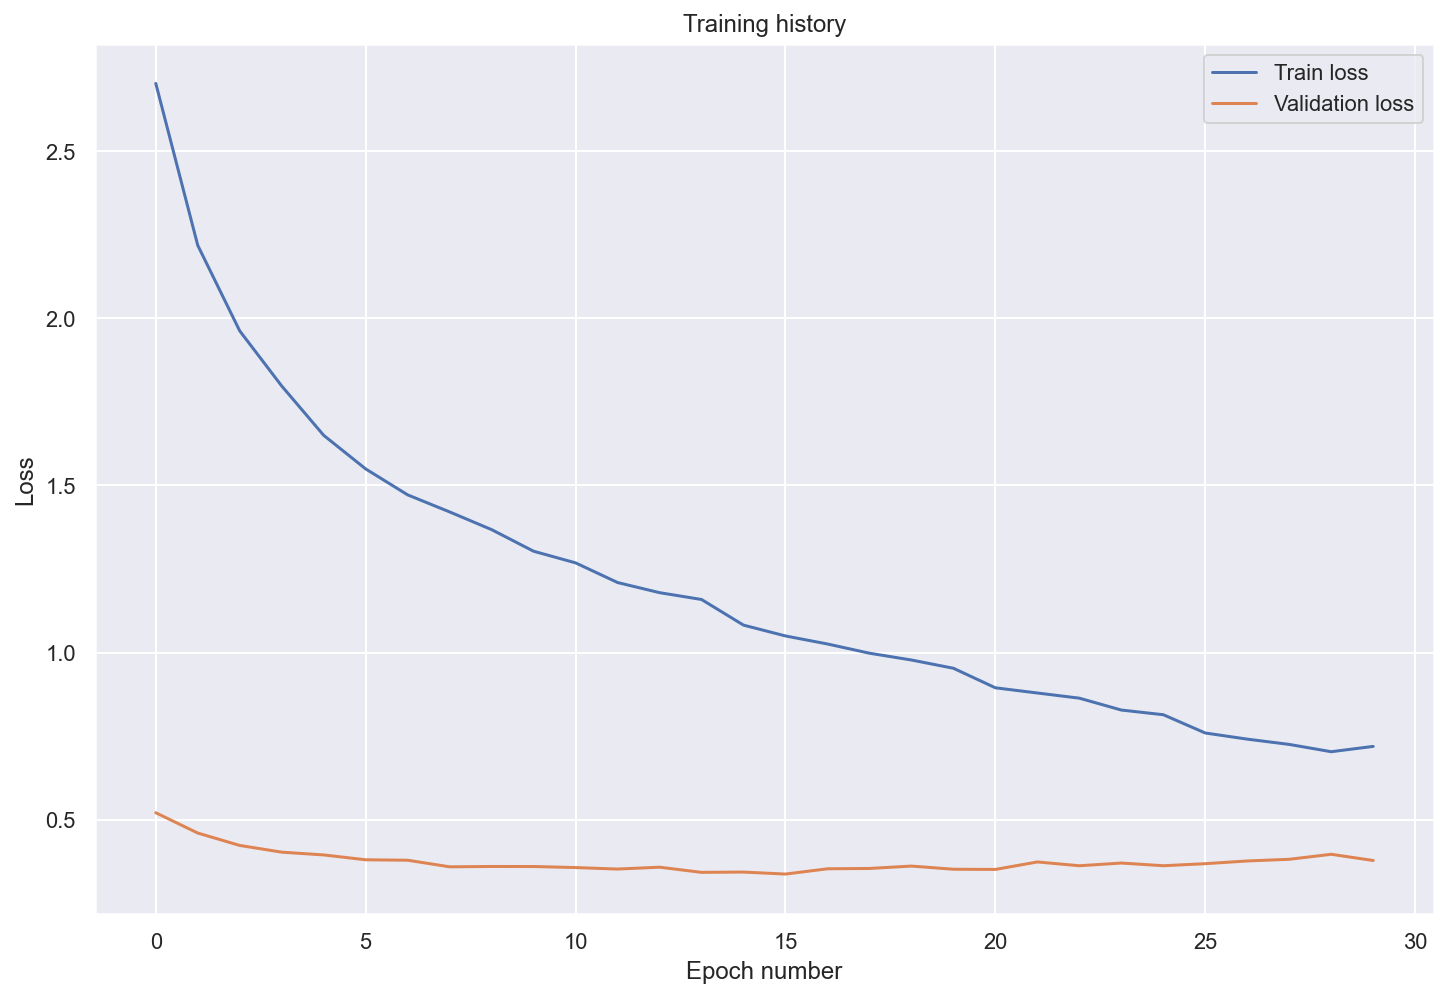

In [149]:
epochs_number = np.arange(30)
sns.lineplot(x = epochs_number, y = train_loss_history, label='Train loss')
sns.lineplot(x = epochs_number, y = valid_loss_history, label='Validation loss') 
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.title('Training history')
plt.show()

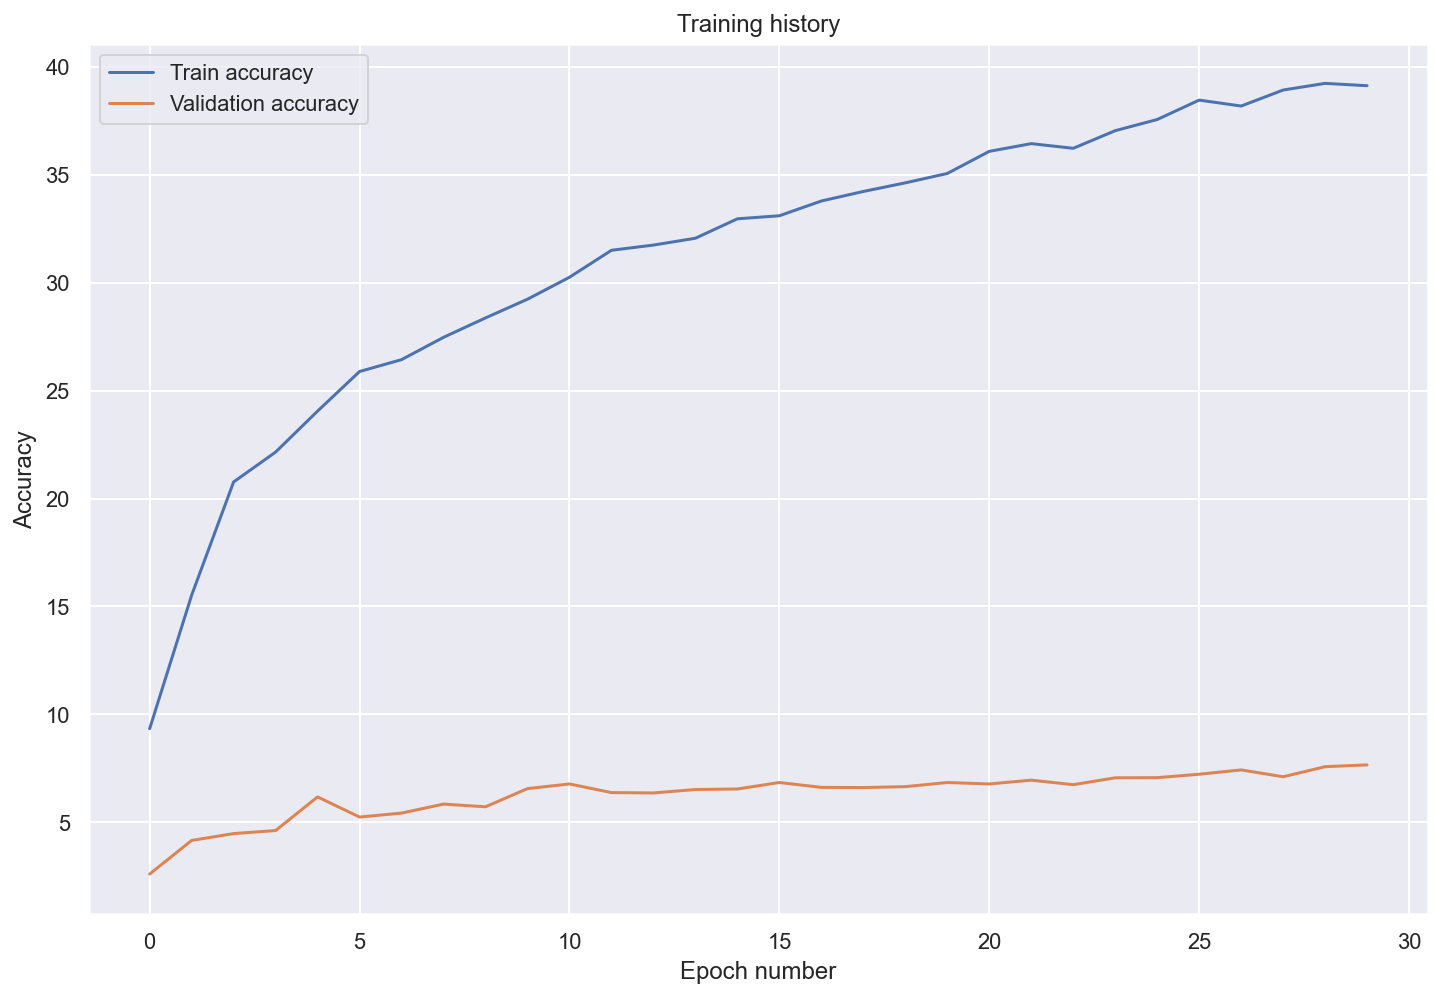

In [150]:
sns.lineplot(x = epochs_number, y = train_accuracy_history, label='Train accuracy')
sns.lineplot(x = epochs_number, y = valid_accuracy_history, label='Validation accuracy') 
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.title('Training history')
plt.show()

In [151]:
final_loss, final_accuracy = evaluate(model, test_loader)

In [152]:
print(f'Trained model has final loss = {final_loss} with accuracy = {final_accuracy}')

Trained model has final loss = 0.36276729553937914 with accuracy = 7.616666666666666


In [172]:
for surname in ['koroleva', 'nader', 'phung', 'trump']:
    encoded_surname = torch.tensor(testdata.vocab.encode(surname)).unsqueeze(dim = 0)
    output = model(encoded_surname)
    probabilities = torch.softmax(output, dim = 1)
    probability = probabilities.max().item()
    id_label = probabilities.argmax().item()
    label = testdata.idx2label[id_label]
    print(f'Surname {surname} was classifies as {label} with a probability {probability}')

Surname koroleva was classifies as Russian with a probability 0.9689733982086182
Surname nader was classifies as Arabic with a probability 0.7752707004547119
Surname phung was classifies as Vietnamese with a probability 0.8072687983512878
Surname trump was classifies as Vietnamese with a probability 0.3308013081550598


In [155]:
model.eval()

SurnameClassifier(
  (embedding): Embedding(29, 100, padding_idx=2)
  (rnn): GRU(100, 64, num_layers=4, batch_first=True, dropout=0.1)
  (output): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=18, bias=True)
  )
)